In [1]:
from mmpretrain import init_model
import torch
import matplotlib.pyplot as plt
import numpy as np

from mmpretrain.utils import register_all_modules

from mmpretrain import ImageClassificationInferencer

In [2]:
# 注册模块
register_all_modules()
# 初始化模型
cfg = '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/projects/RS/swin_v2.py'
checkpoint = '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/projects/RS/swin_v2_tiny/epoch_100.pth'
model = init_model(cfg, checkpoint, device='cuda')  # 或 device='cpu'
inferencer = ImageClassificationInferencer(model)

05/19 16:12:19 - mmengine - INFO - Because batch augmentations are enabled, the data preprocessor automatically enables the `to_onehot` option to generate one-hot format labels.
Loads checkpoint by local backend from path: /icislab/volume3/benderick/futurama/openmmlab/mmpretrain/projects/RS/swin_v2_tiny/epoch_100.pth
05/19 16:12:19 - mmengine - INFO - Delete `relative_position_index` and `relative_coords_table` since we always re-init these params according to the `window_size`, which might cause unwanted but unworried warnings when loading checkpoint.
The model and loaded state dict do not match exactly

missing keys in source state_dict: backbone.stages.0.blocks.0.attn.w_msa.relative_coords_table, backbone.stages.0.blocks.0.attn.w_msa.relative_position_index, backbone.stages.0.blocks.1.attn.w_msa.relative_coords_table, backbone.stages.0.blocks.1.attn.w_msa.relative_position_index, backbone.stages.1.blocks.0.attn.w_msa.relative_coords_table, backbone.stages.1.blocks.0.attn.w_msa.relat

In [3]:
# Swin v2
# 准备一个空字典保存多层特征
features = {}

# 定义通用 hook 函数，带层名参数
def make_hook(layer_name):
    def hook_fn(module, input, output):
        t = output.detach().cpu()
        B, L, C = t.shape
        H, W = int(np.sqrt(L)), int(np.sqrt(L))
        features[layer_name] = t.view(B, H, W, C).permute([0, 3, 1, 2])
        
    return hook_fn

# 注册多个层的 hook
model.backbone.patch_embed.norm.register_forward_hook(make_hook('downsample_4x'))
model.backbone.stages[1].downsample.norm.register_forward_hook(make_hook('downsample_8x'))
model.backbone.stages[2].downsample.norm.register_forward_hook(make_hook('downsample_16x'))
model.backbone.stages[3].downsample.norm.register_forward_hook(make_hook('downsample_32x'))  # 可选的 norm 层
pass

In [4]:
import os
imgs = os.listdir('/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo')
imgs = [os.path.join('/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo', img) for img in imgs]

In [5]:
imgs

['/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/roundabout_165.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/medium_residential_025.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/sparse_residential_649.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/sparse_residential_327.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/medium_residential_019.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/mobile_home_park_628.jpg',
 '/icislab/volume3/benderick/futurama/openmmlab/mmpretrain/data/demo/roundabout_115.jpg']

In [6]:
result = inferencer(imgs, batch_size=32)

Output()

In [7]:
for i in result:
    print
    print(i['pred_class'])


intersection
medium_residential
sparse_residential
sparse_residential
medium_residential
mobile_home_park
roundabout


In [8]:
# 推理后，你可以查看：
for name, feat in features.items():
    print(f"{name}: shape = {feat.shape}", feat.min().item(), feat.max().item(), feat.mean().item(), feat.std().item())

downsample_4x: shape = torch.Size([7, 96, 64, 64]) -7.1820149421691895 6.867241382598877 -0.0030046275351196527 1.1209059953689575
downsample_8x: shape = torch.Size([7, 192, 32, 32]) -7.40704870223999 8.624287605285645 6.38182827970013e-05 1.292805552482605
downsample_16x: shape = torch.Size([7, 384, 16, 16]) -9.024030685424805 7.871910572052002 0.00429875124245882 1.4645239114761353
downsample_32x: shape = torch.Size([7, 768, 8, 8]) -23.07921028137207 19.602649688720703 0.02059057354927063 1.1998823881149292


In [21]:
feat = features['downsample_32x']  # 获取指定层的特征图，例如 (B, C, H, W) 的形状
feat = feat[0]  # 取第一个批次，形状变为 (C, H, W)
C = feat.shape[0]  # 获取通道数

sl = sorted(range(C), key=lambda x: abs(feat[x].mean()), reverse=True)  # 按照均值排序


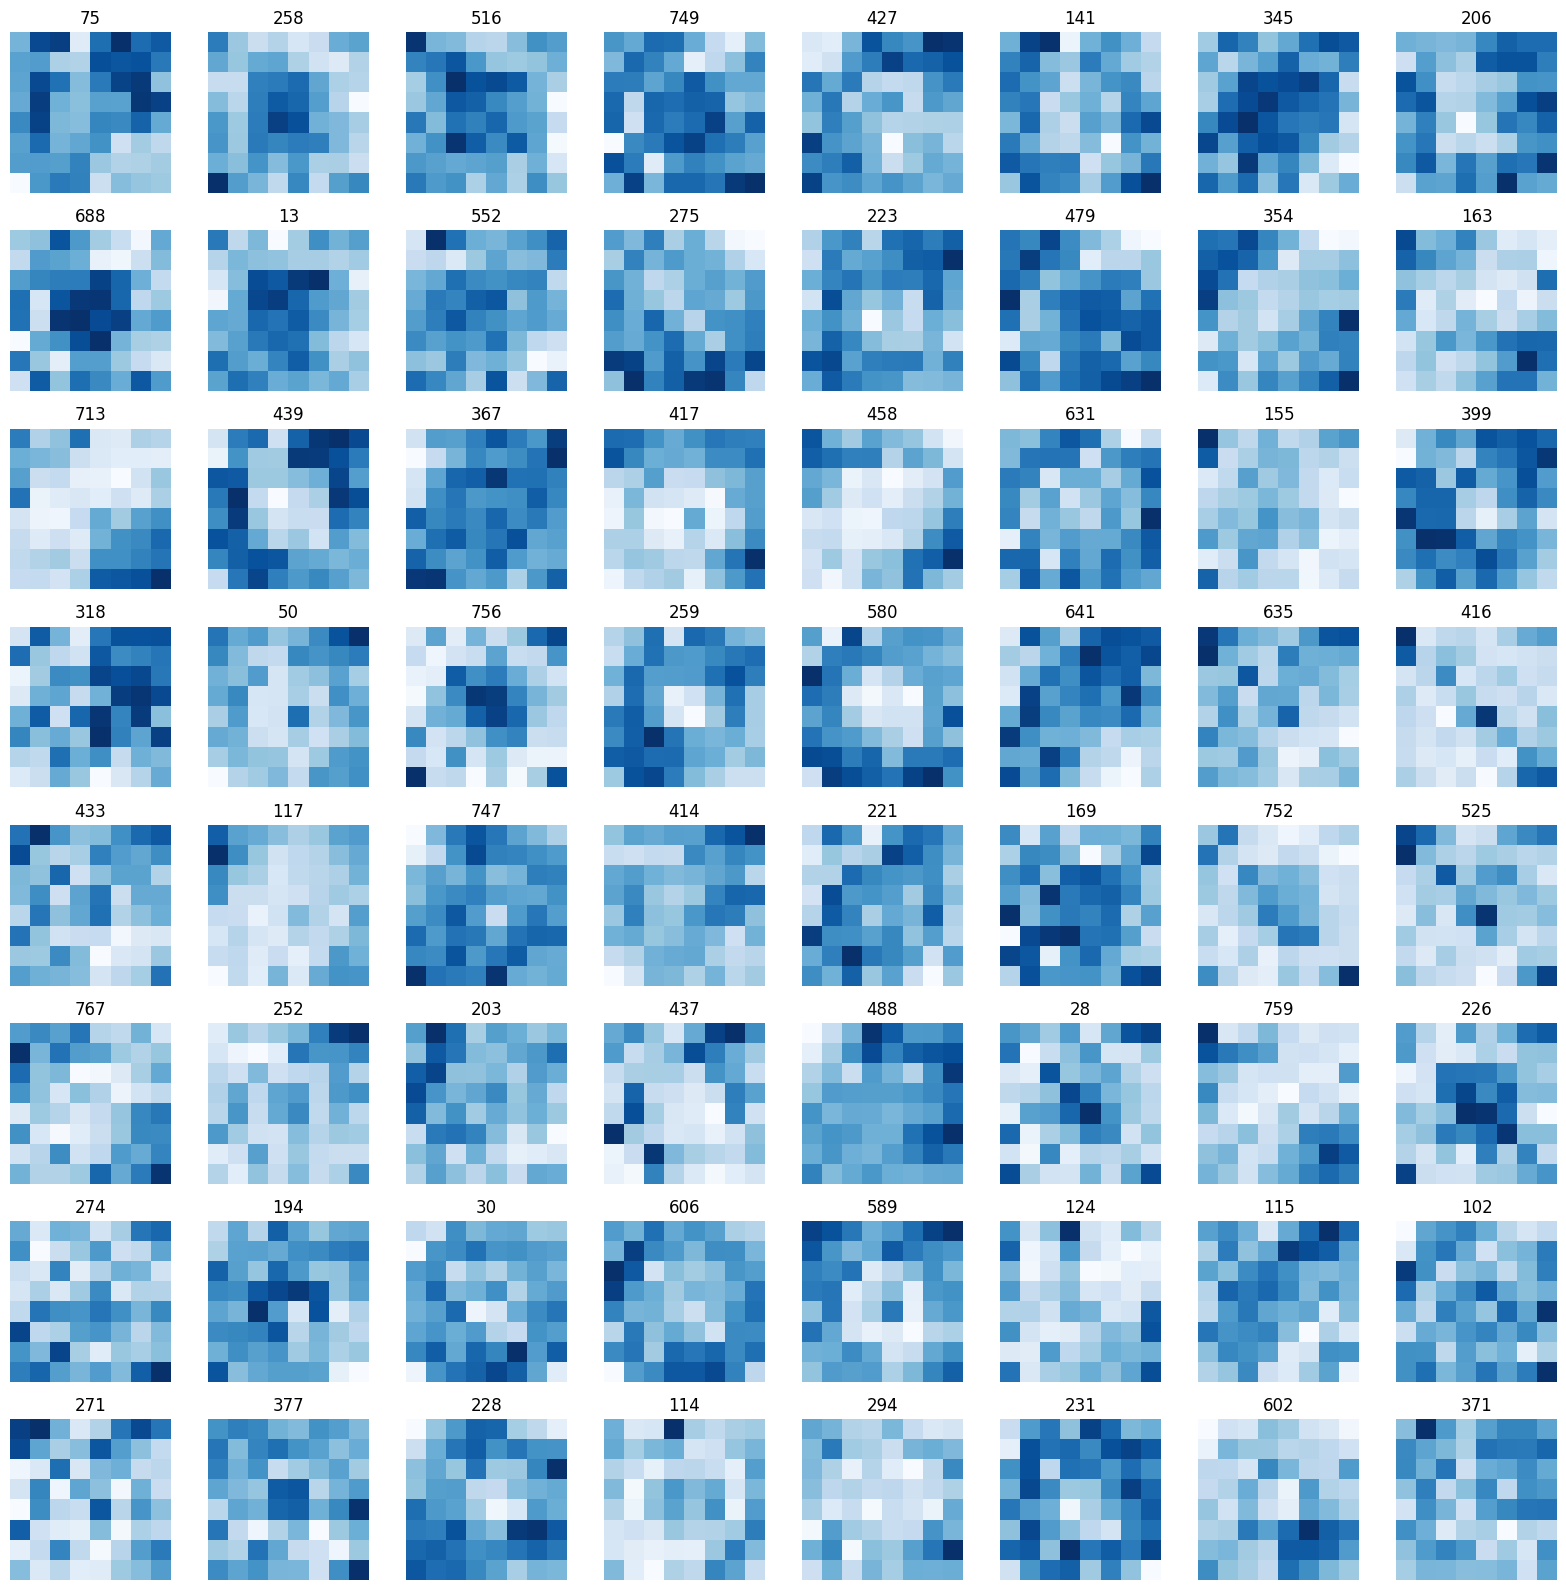

In [24]:

# 设置固定的行数
n_rows = 8  # 固定为8行

# 计算需要的列数（向上取整以确保能显示所有通道）
n_cols = 8

sl = sl[:n_cols*n_rows]

# 创建一个更美观的图表布局
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))  # 每个子图 2x2 英寸

# 将axes展平为一维数组以便于索引
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]


# 遍历所有通道并绘制
for i,c in enumerate(sl):
    if i < C:  # 确保索引有效（不超出通道数）
        # 显示该通道的特征图
        im = axes[i].imshow(feat[c], cmap='Blues')
        # axes[i].set_title(f'{feat[i].mean():.2f}')
        axes[i].set_title(f'{c}')
        
    else:
        # 隐藏多余的子图
        axes[i].axis('off')
        axes[i].set_visible(False)
    
    # 对所有有效的子图，隐藏坐标轴
    if i < C:
        axes[i].axis('off')

# 调整布局，添加总标题
plt.tight_layout()

# 可选：保存高分辨率图像
# plt.savefig('./figs/swin_32x.png', dpi=600, format='png', bbox_inches='tight')
# 显示图像
plt.show()


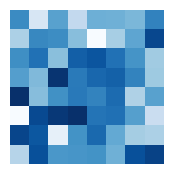

In [26]:
# 假设 feat 是形状为 (B, C, H, W) 的特征图，这里只显示第一个batch
feat = features['downsample_32x']  # 例如 (1, 32, 56, 56)
feat = feat[0]  # 取第一个batch，形状变为 (C, H, W)
C =  169 # 通道数

# 创建子图，每个通道一行
plt.figure(figsize=(2, 2))  # 每行高2英寸，宽4英寸


plt.imshow(feat[C], cmap='Blues')  # 显示第i个通道
plt.axis('off')
plt.savefig(f'./figs/swin_32x_C{C}.png', dpi=600, format='png', bbox_inches='tight', pad_inches=0,transparent=True)
plt.show()

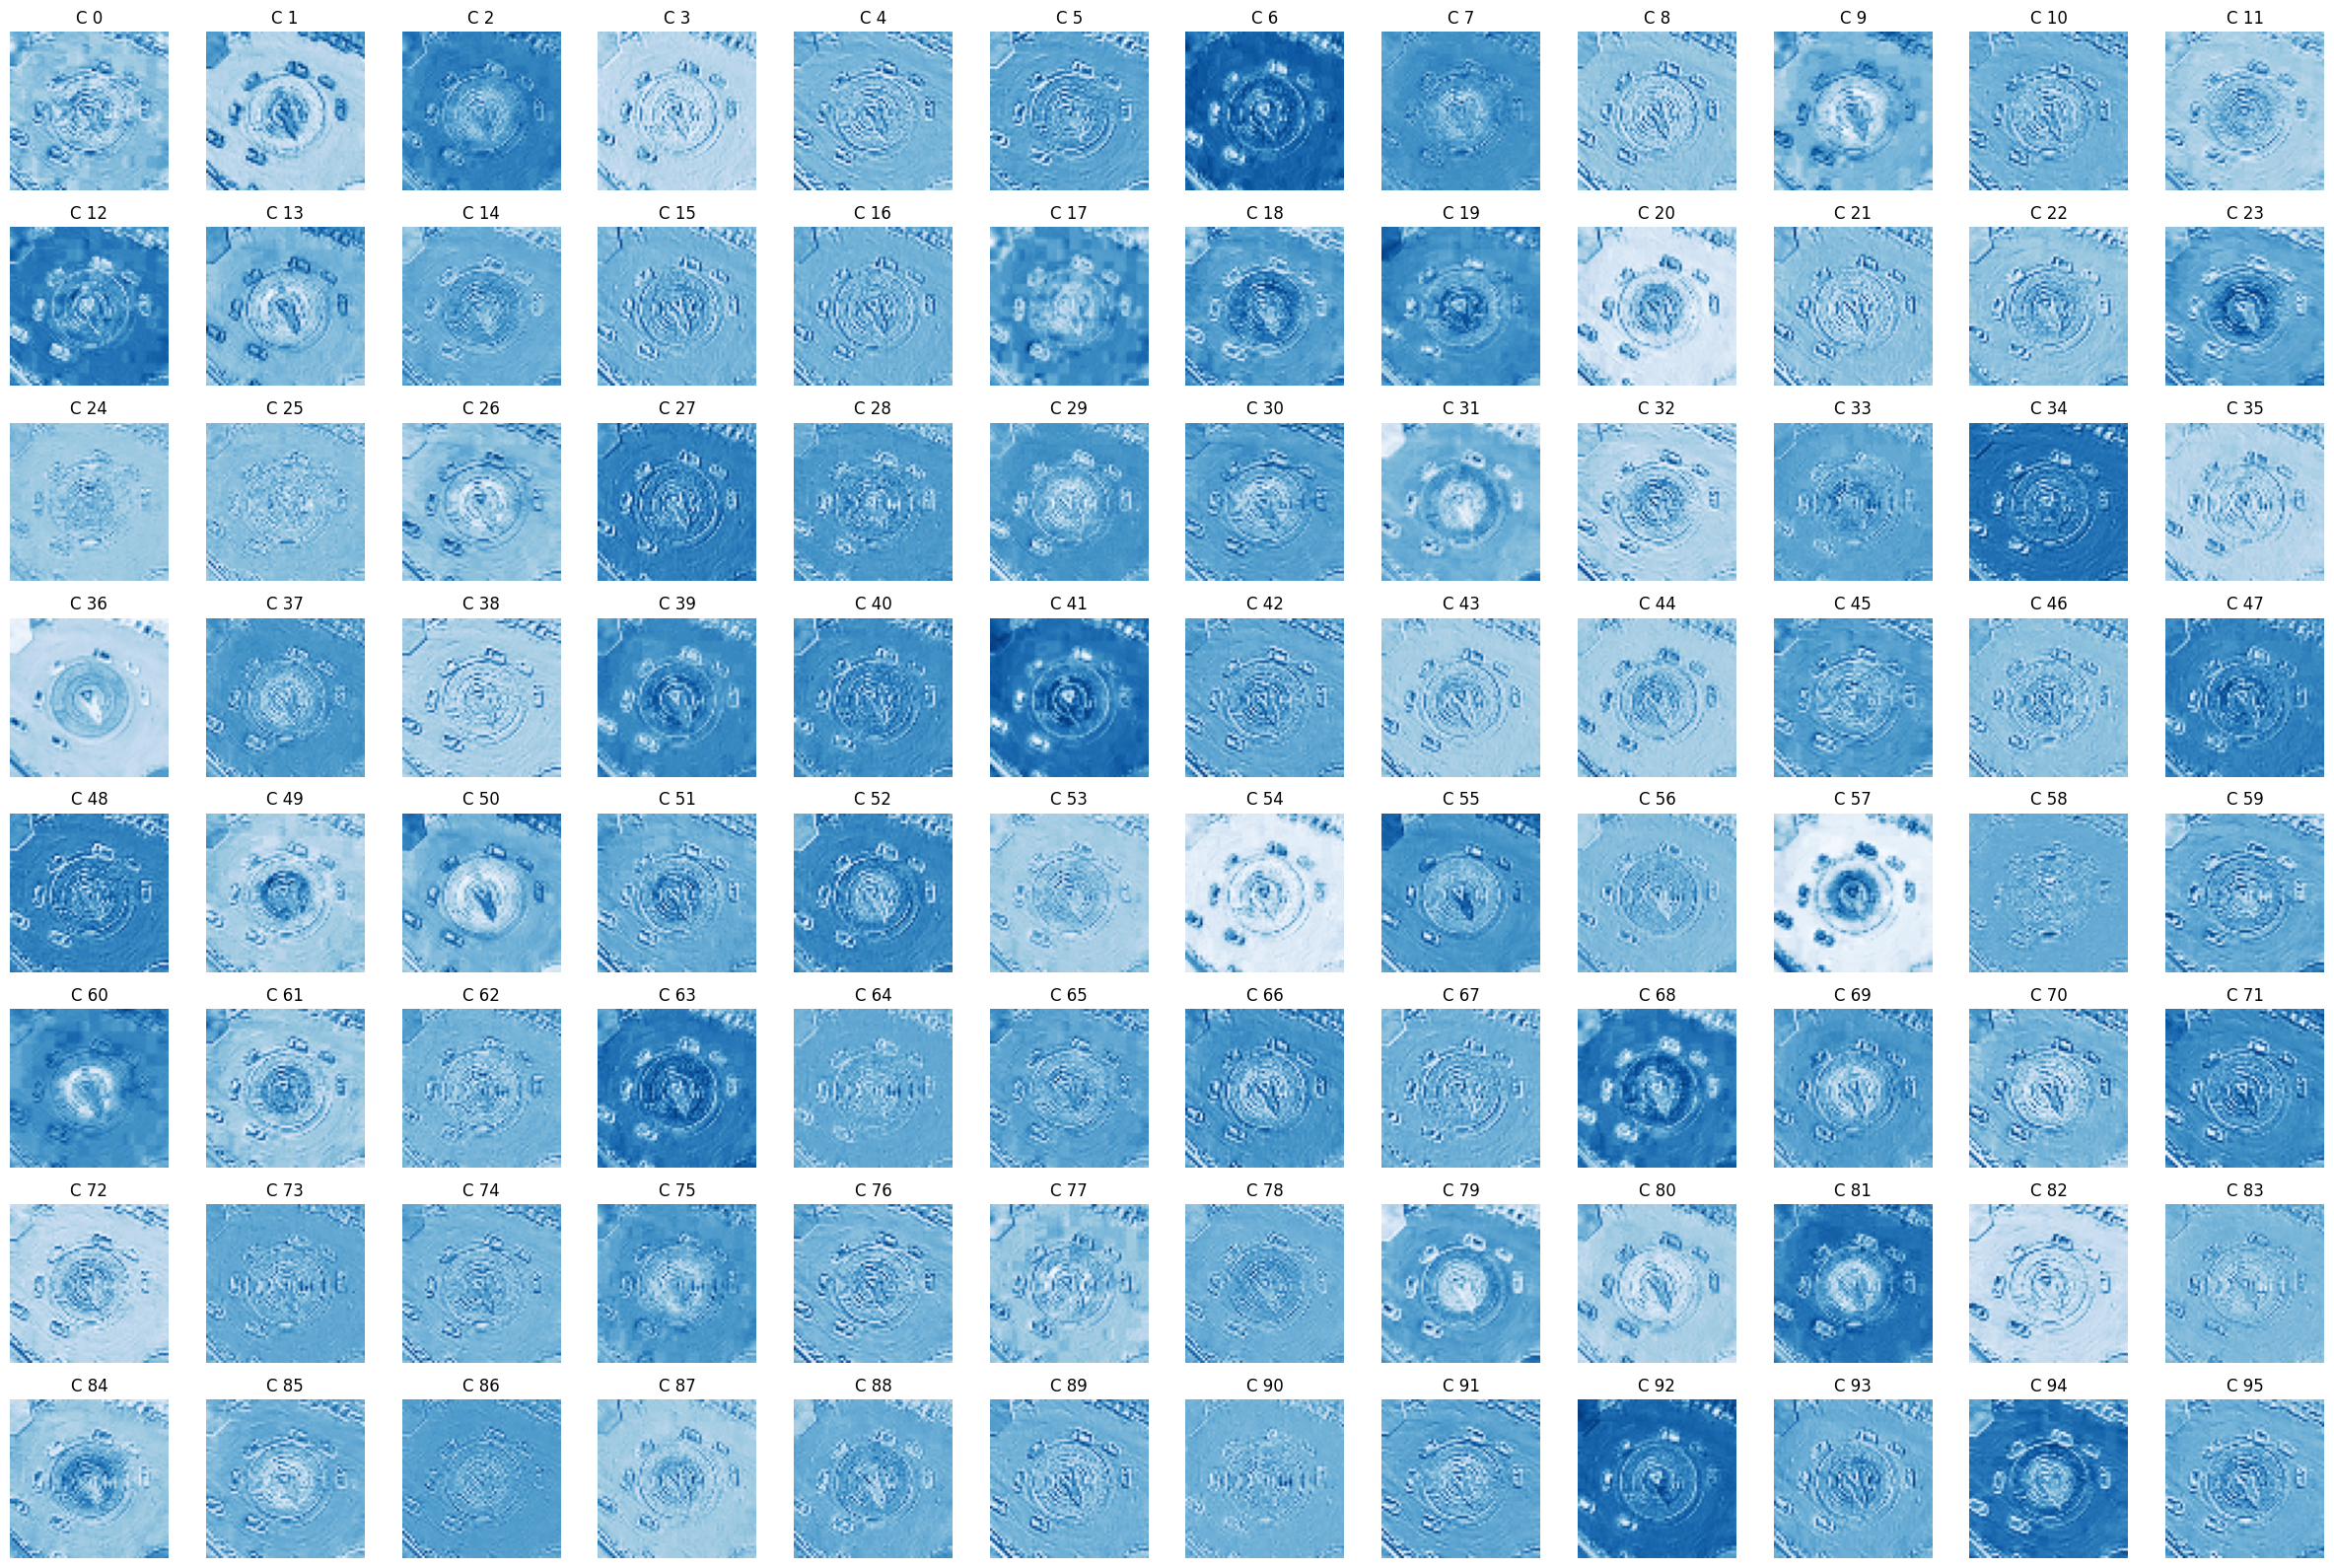

In [ ]:
# 获取特征图数据
feat = features['downsample_4x']  # 获取指定层的特征图，例如 (B, C, H, W) 的形状
feat = feat[0]  # 取第一个批次，形状变为 (C, H, W)
C = feat.shape[0]  # 获取通道数

# 设置固定的行数
n_rows = 8  # 固定为8行

# 计算需要的列数（向上取整以确保能显示所有通道）
n_cols = int(np.ceil(C / n_rows))

# 创建一个更美观的图表布局
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))  # 每个子图 2x2 英寸

# 将axes展平为一维数组以便于索引
axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

# 遍历所有通道并绘制
for i in range(n_rows * n_cols):
    if i < C:  # 确保索引有效（不超出通道数）
        # 显示该通道的特征图
        im = axes[i].imshow(feat[i], cmap='Blues')
        axes[i].set_title(f'C {i}')
    else:
        # 隐藏多余的子图
        axes[i].axis('off')
        axes[i].set_visible(False)
    
    # 对所有有效的子图，隐藏坐标轴
    if i < C:
        axes[i].axis('off')

# 调整布局，添加总标题
plt.tight_layout()

# plt.savefig('./figs/swin_4x.png', dpi=600, format='png', bbox_inches='tight')

# 显示图像
plt.show()
